# <center> Линейная алгебра в контексте линейных методов. Практика.

## <center> Прогнозирование выработки газа на скважинах.

## Постановка задачи

У Василия, основателя компании «Газ-Таз-Ваз-Нефть», дела идут в гору: у него уже функционирует 200 скважин для добычи газа. В этом году он открывает 30 новых скважин. Однако в целях оптимизации расходов и повышения дохода Василию необходимо оценить, сколько денег будет приносить ему каждая из скважин, а также понять, какие факторы (параметры скважин) потенциально сильнее всего повлияют на объём добычи газа. Для этого Василий решил нанять вас как специалиста в области Data Science.

Василий представляет вам набор данных о добыче газа на своих скважинах. Файл с данными вы можете скачать на платформе.

**Признаки в данных:**

* Well — идентификатор скважины;
* Por — пористость скважины (%);
* Perm — проницаемость скважины;
* AI — акустический импеданс ($кг/м^2 * 10^6$);
* Brittle — коэффициент хрупкости скважины (%);
* TOC — общий органический углерод (%);
* VR — коэффициент отражения витринита (%);
* Prod — добыча газа в сутки (млн. кубических футов).

**Ваша задача** — построить регрессионную модель, которая прогнозирует выработку газа на скважине (целевой признак — Prod) на основе остальных характеристик скважины, и проинтерпретировать результаты вашей модели.

Разделим задачу на две части:
* В первой мы построим простейшую модель линейной регрессии, проанализируем результаты её работы и выберем наиболее значимые факторы для прогнозирования.
* Во второй мы займёмся построением модели полиномиальной регрессии с регуляризацией и посмотрим на итоговые результаты моделирования.


Импортируем необходимые библиотеки:

In [1]:
# Импорт библиотек
import numpy as np # для работы с массивами
from sklearn.linear_model import LinearRegression
from sklearn import metrics 
import pandas as pd # для работы с DataFrame 
import seaborn as sns # библиотека для визуализации статистических данных
import matplotlib.pyplot as plt # для построения графиков
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline


Прочитаем исходные данные:

In [2]:
data = pd.read_csv('unconv.csv')
data.head()


,Well,Por,Perm,AI,Brittle,TOC,VR,Prod
0,1,12.08,2.92,2.80,81.40,1.16,2.31,4165.196191
1,2,12.38,3.53,3.22,46.17,0.89,1.88,3561.146205
2,3,14.02,2.59,4.01,72.80,0.89,2.72,4284.348574
3,4,17.67,6.75,2.63,39.81,1.08,1.88,5098.680869
4,5,17.52,4.57,3.18,10.94,1.51,1.90,3406.132832


## Практика: линейная регрессия по методу наименьших квадратов

Для начала построим простейшую модель линейной регрессии, проанализируем результаты её работы и выберем наиболее значимые факторы для прогнозирования.

В первой части вам предстоит выполнить задания 5.0–5.6. Максимальное количество баллов, которое можно получить, — 9.

### Задание 5.0. (не оценивается)

Проведите небольшой разведывательный анализ, чтобы поближе познакомиться с исходными данными. Постройте несколько визуализаций, которые помогут вам понять, как устроены исходные признаки, а также смогут продемонстрировать взаимосвязь факторов. 

Сделайте промежуточные выводы из проведённого разведывательного анализа.

In [3]:
data.describe()


,Well,Por,Perm,AI,Brittle,TOC,VR,Prod
count,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000
mean,100.500000,14.991150,4.330750,2.968850,48.161950,0.990450,1.964300,4311.219852
std,57.879185,2.971176,1.731014,0.566885,14.129455,0.481588,0.300827,992.038414
min,1.000000,6.550000,1.130000,1.280000,10.940000,-0.190000,0.930000,2107.139414
25%,50.750000,12.912500,3.122500,2.547500,37.755000,0.617500,1.770000,3618.064513
50%,100.500000,15.070000,4.035000,2.955000,49.510000,1.030000,1.960000,4284.687348
75%,150.250000,17.402500,5.287500,3.345000,58.262500,1.350000,2.142500,5086.089761
max,200.000000,23.550000,9.870000,4.630000,84.330000,2.180000,2.870000,6662.622385


In [4]:
numeric = data.dtypes.index.to_list()

def outliers_iqr_mod(data, feature, left=1.5, right=1.5, log_scale=False):
    if log_scale:
        x = np.log(data[feature])
    else:
        x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - left*iqr
    upper_bound = quartile_3 + right*iqr
    left_outlier, right_outlier = data[x < lower_bound], data[x > upper_bound]
    cleaned = data[(x>lower_bound) & (x < upper_bound)]
    return left_outlier, right_outlier, cleaned

for n in numeric:
    left_outlier, right_outlier, cleaned = outliers_iqr_mod(data, n)
    print('Число выбросов в',n,' с меньшей стороны по методу z-отклонения:', left_outlier.shape[0])
    print('Число выбросов в',n,'с большей стороны по методу z-отклонения:', right_outlier.shape[0])


Число выбросов в Well  с меньшей стороны по методу z-отклонения: 0
Число выбросов в Well с большей стороны по методу z-отклонения: 0
Число выбросов в Por  с меньшей стороны по методу z-отклонения: 0
Число выбросов в Por с большей стороны по методу z-отклонения: 0
Число выбросов в Perm  с меньшей стороны по методу z-отклонения: 0
Число выбросов в Perm с большей стороны по методу z-отклонения: 5
Число выбросов в AI  с меньшей стороны по методу z-отклонения: 1
Число выбросов в AI с большей стороны по методу z-отклонения: 1
Число выбросов в Brittle  с меньшей стороны по методу z-отклонения: 0
Число выбросов в Brittle с большей стороны по методу z-отклонения: 0
Число выбросов в TOC  с меньшей стороны по методу z-отклонения: 0
Число выбросов в TOC с большей стороны по методу z-отклонения: 0
Число выбросов в VR  с меньшей стороны по методу z-отклонения: 2
Число выбросов в VR с большей стороны по методу z-отклонения: 3
Число выбросов в Prod  с меньшей стороны по методу z-отклонения: 0
Число вы

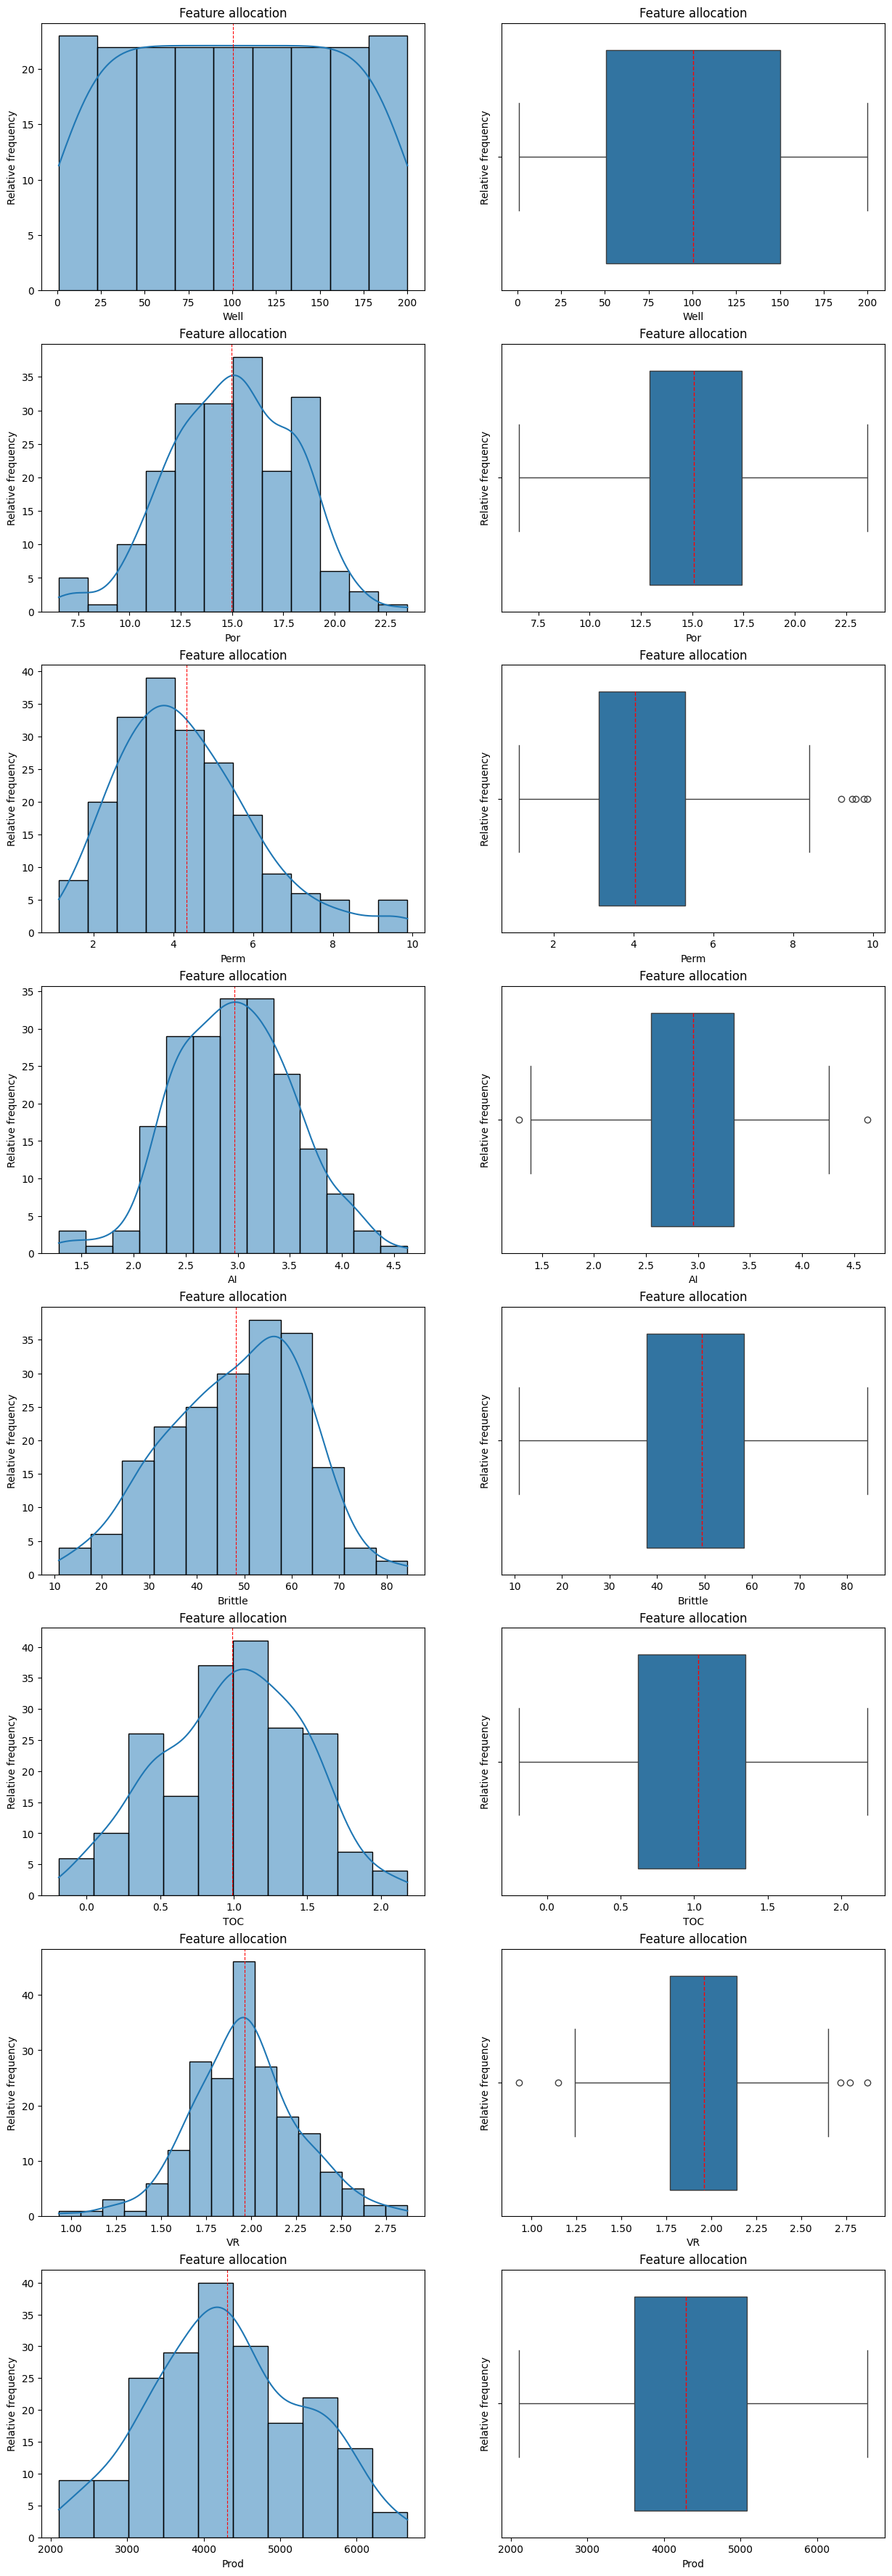

In [5]:
n = len(numeric) #количество числовых признаков
fig, axes = plt.subplots(n, 2, figsize = (15, 45)) # фигура + n х 2 координатных плоскостей
for i, f in enumerate(numeric): #i- индекс, feature - название признака в таблице
    
    sns.histplot(data[f], kde=True, ax=axes[i][0])
    axes[i][0].set(xlabel=f, ylabel='Relative frequency')
    axes[i][0].set_title('Feature allocation')
    axes[i][0].axvline(data[f].mean(), color='red', linestyle='--', linewidth=0.8)

    sns.boxplot(data[f], ax=axes[i][1], orient='h', medianprops={"color": "r", "linestyle": '--'})
    axes[i][1].set(xlabel=f, ylabel='Relative frequency')
    axes[i][1].set_title('Feature allocation')
plt.show()


Признак well неинформативен, т.к. суть его - это индексация.
В некоторых признаках присутствуют выбросы.
Признаки представлены нормальным распределением (колокол).

### Задание 5.1. (2 балла)

Постройте корреляционную матрицу факторов, включив в неё целевой признак. 

Для наглядности визуализируйте полученную матрицу с помощью тепловой карты. 

**Примечание.** *Для визуализации вы можете использовать любую из знакомых вам библиотек.*

На основе построенной корреляционной матрицы ответьте на следующий вопрос:

* Какие факторы сильнее всего коррелируют с целевой переменной?

Вычислите ранг и определитель полученной матрицы корреляций и приведите развёрнутые ответы на следующие вопросы:
* Является ли корреляционная матрица плохо обусловенной (близок ли её опредитель к нулю)?
* Что вы можете сказать о наличии коллинераности/мультиколлинеарности в данных? 
* Применима ли в данном случае модель классической линейной регрессии по методу наименьших квадратов и почему? 

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * приведён код для расчёта корреляционной матрицы;
    * приведён код для визуализации корреляционной матрицы в виде тепловой карты;
    * рассчитаны ранг и определитель корреляционной матрицы;
    * предоставлены обоснованные ответы на все поставленные вопросы. 

- Задание выполнено верно, но не учтено одно условие (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

Ранг матрицы равен: 8
Число обусловленности матрицы: 153.0
Определитель матрицы равен: 0.00073


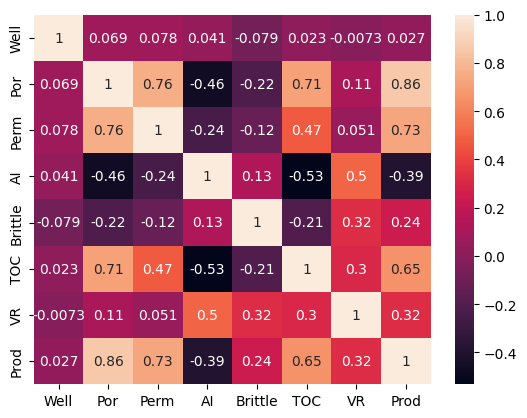

In [6]:
df_corr = data[numeric].corr()
sns.heatmap(df_corr, annot = True)
m_det = np.linalg.det(df_corr)
m_rank = np.linalg.matrix_rank(df_corr)
m_cond = np.linalg.cond(df_corr)

print('Ранг матрицы равен:', m_rank)
print('Число обусловленности матрицы:', m_cond.round())
print('Определитель матрицы равен:', m_det.round(5))


Вывод: Сильнее всего (0.7-0.9) с целевой переменной коррелируют признаки Por и Perm.
Средняя связь (0.5-0.7) у целевой переменной проявляется с признаком TOC.
Также у пар признаков Por/TOC, Por/Perm есть сильные прямые корреляционные связи > 0.7.

Т.к. ранг матрицы равен кол-ву признаков, то матрица яляется невырожденной матрицей - матрицей полного ранга.
Число обусловленности нашей матрицы равно 153. (Из сети :"Матрицы с большим числом обусловленности (∼ 1000 и выше) называются плохо обусловленными".)

Наличие явной мультиколлинеарности неочевидно, т.к. нет пар с коэф. корреляции забегающих за +/-0.9. Но в пределе сильной зависимости мультиколлинеарность проявляется.

Т.к. матрица не является вырожденной то метод МНК применим. 

### Задание 5.2. (2 балла)

Создайте матрицу наблюдений `X` и вектор правильных ответов `y`. В качестве факторов для матрицы наблюдений возьмите все имеющиеся в данных признаки. 

Постройте модель линейной регрессии по методу наименьших квадратов. Для этого воспользуйтесь матричной формулой МНК и инструментарием библиотеки numpy. 

Выведите на экран полученные оценки коэффициентов модели, округлённые до целого.

Приведите подробные выводы по полученным результатам, ответив на следующие вопросы:
* Есть ли в ваших данных признаки, которые, согласно модели, можно назвать неинформативными, то есть они не оказывают влияния на целевую переменную или оказывают шумовое влияние?
* Приведите интерпретацию нескольких (двух или трёх) коэффициентов полученной модели линейной регрессии.


**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * приведён код для нахождения параметров модели линейной регрессии с помощью матричной формулы МНК;
    * на основе полученных параметров даны верные ответы на поставленные вопросы;
    * приведена корректная интерпретация нескольких коэффициентов полученной модели линейной регрессии.

- Задание выполнено верно, но не учтено одно из условий (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [7]:
# Ваш код здесь
X = data.drop(['Prod'], axis=1)
#X = np.column_stack((np.ones(200), X))
y = data['Prod']

# вычислим OLS-оценку для коэффициентов
w_hat=np.linalg.inv(X.T@X)@X.T@y
print(w_hat.round()) 


0      -0.0
1     185.0
2     158.0
3    -676.0
4      20.0
5    -273.0
6    1125.0
dtype: float64


Вывод: Из семи признаков есть один неинформативный со значением коэффициента 0, о чем было упоминание в задание 5.1 Выводы. Признак well с коэффициентом 0 не оказывает влияния на целевую переменную.

На нестандартизированных данных коэффициенты под номерами 6, 3, 5 имеет большее влияние на целевую переменную, чем Коэффициенты под номерами 1, 2, 4. При наличии мультиколлинеарности интерпретация не имеет смысла.

### Задание 5.3. (1 балл)

Теперь потренируемся строить предсказание для наблюдений целевой переменной. 

**а)** Постройте прогноз выработки газа для скважины со следующими параметрами:

```python
{
    'Well': 106.0,
    'Por': 15.32,
    'Perm': 3.71,
    'AI': 3.29,
    'Brittle': 55.99,
    'TOC': 1.35,
    'VR': 2.42
 }
```

Рассчитайте абсолютную ошибку построенного вами прогноза для предложенной скважины (в миллионах кубических футов в день), если известно, что на этой скважине производится `4748.315024` миллионов кубических футов газа в день. 

**б)** Постройте прогноз выработки газа для всех скважин из обучающего набора данных. Выберите метрику, по которой вы будете оценивать качество регрессионных моделей и сравнивать их между собой (можно использовать несколько метрик, но не более двух).

Рассчитайте значение выбранной метрики для вашей модели. Приведите интерпретацию полученного результата. 

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балл**): 
    * приведён код для построения прогноза выработки газа на указанной скважине и рассчитана абсолютная ошибка прогноза для этой скважины;
    * выбрана корректная для поставленной задачи метрика (или метрики) оценки качества модели и приведён код для расчёта этой метрики на всём обучающем наборе данных;
    * приведена корректная интерпретация полученного результата.

- Задание выполнено верно, но не учтено одно из условий, или задание выполнено неверно (**0 баллов**).

In [8]:
# новое наблюдение
new = {
    'Well': 106.0,
    'Por': 15.32,
    'Perm': 3.71,
    'AI': 3.29,
    'Brittle': 55.99,
    'TOC': 1.35,
    'VR': 2.42
 }

real_prod = [4748.315024]   # истинное значение выработки скважины миллионов кубических футов газа в день

#прогноз для нвового наблюдения
new = np.array([list(new.values())])
new_prod_pred = new@w_hat
print('prediction:', new_prod_pred)
#вывод метрики
print('MAPE:', metrics.mean_absolute_percentage_error(real_prod, new_prod_pred))

#прогноз для исходного набора
print(X.shape, w_hat.shape)
y_train_pred = np.array(X)@w_hat
#вывод метрики
print('R2:', metrics.r2_score(y, y_train_pred))


prediction: [4631.7085706]
MAPE: 0.024557438335459657
(200, 7) (7,)
R2: 0.9502953006218579


Вывод: показатель\метрика r2-score близка к 1, что значит модель очень хорошо улавливает долю разнообразия\дисперсии в данных.

### Задание 5.4. (1 балл)

Настало время анализа построенной модели. Посмотрите на коэффициенты и сравните их знаки со значениями выборочных корреляций между целевым признаком и факторами, которые вы нашли ранее.

Дайте развёрнутые ответы на следующие вопросы:

* Есть ли в вашей модели фактор, при котором коэффициент в модели линейной регрессии противоречит соответствующему коэффициенту корреляции? Например, корреляция говорит, что зависимость между фактором и целевой переменной прямая, а модель говорит обратное. Если таких факторов несколько, укажите их все.
* Как вы считаете, с чем связано полученное противоречие результатов?

**Критерии оценивания:**

- Задание выполнено верно, даны корректные развёрнутые ответы на все поставленные в задании вопросы (**1 балл**). 

- Задание выполнено неверно, даны некорректные ответы на один или несколько поставленных в задании вопросов (**0 баллов**).

In [9]:
prod_coef = df_corr.iloc[:-1,-1]
ind = df_corr.columns.to_list()
for n,m,i in zip(prod_coef, w_hat, ind):
    if (n<0 and m>0) or (n>0 and m<0): 
        print('Для пары Prod и', i,'направленность коэффициента неодинакова')
        print(n,m)


Для пары Prod и Well направленность коэффициента неодинакова
0.02681677681635362 -0.04344960055407032
Для пары Prod и TOC направленность коэффициента неодинакова
0.6544451995719837 -272.9838262903405


Вывод: для пар признаков Prod/Well и Prod/TOC направленность коэффициента неодинакова.
Это обусловлено тем, что признаки, а значит и коэффициенты линейной регрессии, лежат в разных масштабах. Чтобы говорить о важности влияния признаков на модель, нужно строить её на стандартизированных данных.

### Задание 5.5. (2 балла)

* Исключите из данных сильно коррелированные между собой факторы. Под сильной корреляцией в данной задаче будем понимать значения выше `0.7`.

Выбирая, какой из коррелированных факторов оставить, руководствуйтесь коэффициентом корреляции с целевой переменной: оставляйте тот фактор, который больше всего коррелирует с целевой переменной (объёмом добычи газа).

* Также исключите из данных факторы, для которых корреляция с целевой переменной меньше `0.05`.

Постройте модель линейной регрессии на обновлённых после удаления факторов данных по методу наименьших квадратов. Для этого используйте матричную формулу и библиотеку numpy. Выведите значение полученных коэффициентов, округлённых до целого.

Сделайте прогноз для всего обучающего набора данных и рассчитайте выбранную вами ранее метрику (или метрики). 

Дайте подробные ответы на следующие вопросы:

* Приведите интерпретацию нескольких полученных коэффициентов (двух или трёх). Сравните их значения с полученными ранее.
* Приведите интерпретацию полученных значений метрик. Сравните их значения с полученными ранее. 
* Удалось ли вам побороть противоречие коэффициентов линейной регрессии и коэффициентов корреляции?

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * отобраны верные факторы;
    * на основе отобранных факторов построена модель линейной регрессии с помощью матричной формулы МНК и найдены параметры модели, соответствующие каждому из факторов;
    * построен прогноз для всего обучающего набора данных и рассчитано значение метрики (метрика должна быть выбрана корректно);
    * даны ответы на все поставленные в задании вопросы.

- Задание выполнено верно, но не учтено одно из условий (**1 балл**).
- Задание выполнено верно, не учтено несколько из условий (**0 баллов**).

0    235.0
1   -486.0
2     22.0
3    598.0
dtype: float64 
 
(200, 4) (4,)

 R2: 0.9165418332366058


<Axes: >

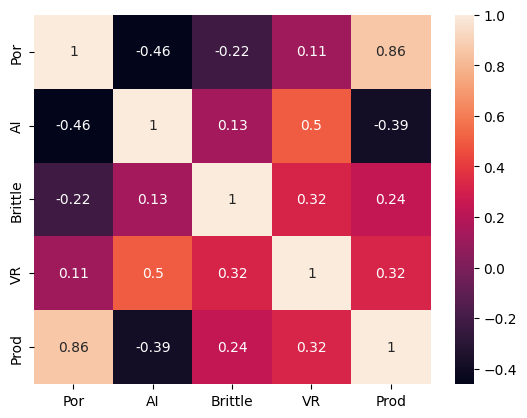

In [10]:
reduced_X = X.drop(['Well', 'TOC', 'Perm'], axis=1)
# вычислим OLS-оценку для коэффициентов
reduced_w_hat=np.linalg.inv(reduced_X.T@reduced_X)@reduced_X.T@y
print(reduced_w_hat.round(),'\n ') 

#прогноз для исходного набора
print(reduced_X.shape, reduced_w_hat.shape)
reduced_y_train_pred = np.array(reduced_X)@reduced_w_hat
#вывод метрики
print('\n R2:', metrics.r2_score(y, reduced_y_train_pred))

sns.heatmap(data.drop(['Well', 'TOC', 'Perm'], axis=1).corr(), annot=True)


In [28]:
# для интепретации создадим вектор средних значений по признаку
mean_vector = [reduced_X.iloc[:,0].mean().round(2), reduced_X.iloc[:,1].mean().round(2), reduced_X.iloc[:,2].mean().round(2), reduced_X.iloc[:,3].mean().round(2)]
mean_vector = np.array(mean_vector)
#получим значение целевой переменной для этого вектора
b_m = mean_vector@reduced_w_hat
print('Base meaning', b_m)
#увеличим значения коэффициентов для признаков Por и Brittle на 10% последовательно.
mean_vector[0] = mean_vector[0]*1.1
n_m = mean_vector@reduced_w_hat
print('New meaning after Por increasing', n_m)
print('Difference, %:', (1-b_m/n_m)*100)
mean_vector[2] = mean_vector[2]*1.1
n_m = mean_vector@reduced_w_hat
print('New meaning after Brittle increasing', n_m)
print('Difference, %:', (1-b_m/n_m)*100)


Base meaning 4323.06473833467
New meaning after Por increasing 4675.601606935595
Difference, %: 7.53992530240356
New meaning after Brittle increasing 4782.480452170106
Difference, %: 9.606222512147866


Вывод: значения коэффициентов для оставшихся признаков изменились с сохранением направленности. Влияние коэффициентов для признаков Por, AI, Brit на модель увеличилось, а коэффициент признака VR уменьшил свое влияние.
Противоречие коэффициентов линейной регрессии и коэффициентов корреляции перестало иметь место т.к. соответствующие признаки были удалены по причине мултиколлениарности или молоинформативности.

### Задание 5.6. (1 балл)

Наконец, давайте построим модель линейной регрессии из библиотеки `scikit-learn (sklearn)` и сравним результаты её работы с теми, что нам удалось получить вручную. 

Постройте модель линейной регрессии на обновлённых после удаления факторов данных по методу наименьших квадратов. Для этого воспользуйтесь классом `LinearRegression` из библиотеки `sklearn`. Выведите значения полученных коэффициентов, округлённые до целого.

Сделайте прогноз для всего обучающего набора данных и рассчитайте значение выбранной вами метрики (или метрик).

Сравните результаты библиотечной реализации с тем, что вы получили ранее. 

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**1 балл**): 
    * на основе отобранных факторов построена модель линейной регрессии из библиотеки sklearn и найдены параметры модели, соответствующие каждому из факторов;
    * построен прогноз для всего обучающего набора данных и рассчитано значение метрики (метрика должна быть выбрана корректно);
    * приведён вывод о соответствии результатов, полученных вручную и с помощью библиотеки.
- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [11]:
# Ваш код здесь


> *Ваши выводы здесь*

## Практика: полиномиальная регрессия и регуляризация

Мы продолжаем работать над задачей от владельца компании «Газ-Таз-Ваз-Нефть» Василия.

Ранее мы построили модель линейной регрессии, которая прогнозирует выработку газа на скважине. Для этого мы с помощью матрицы корреляций и рассуждений отобрали некоррелированные, значимые для предсказания признаки. **Далее мы будем использовать именно их (см. задание 5.5).**

Мы хотим улучшить результат — уменьшить ошибку прогноза. Для этого мы воспользуемся моделью полиномиальной регрессии третьей степени. Однако теперь мы знаем, что полиномиальным моделям очень легко переобучиться под исходную выборку. Так как данных у нас не так много (всего 200 скважин), то для контроля качества модели мы будем использовать кросс-валидацию. 

Приступим! Выполните задания 8.1–8.5:


In [12]:
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate


### Задание 8.1. (1 балл)

Стандаризируйте признаки с помощью `StandartScaler` из библиотеки `sklearn`. 

Затем сгенерируйте полиномиальные признаки третьего порядка на факторах, которые вы выбрали для обучения моделей. Для этого воспользуйтесь генератором полиномов `PolynomialFeatures` из библиотеки `sklearn`. Параметр `include_bias` установите в значение `False`.

Выведите на экран, сколько факторов у вас получилось после генерации полиномиальных признаков.

**Важно:** стандартизацию необходимо произвести до генерации полиномиальных факторов!

Обучите модель линейной регрессии из библиотеки `sklearn` (`LinearRegression`) на полученных полиномиальных факторах.

Используя кросс-валидацию оцените среднее значение выбранной вами метрики (или метрик) на тренировочных и валидационных фолдах.

Проинтерпретируйте полученные результаты.

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**1 балл**): 
    * на основе отобранных факторов сгенерированы полиномиальные признаки третьего порядка;
    * построена модель полиномиальной регрессии (линейной регрессии на полиномиальных признаках);
    * с помощью кросс-валидации оценено среднее значение выбранной студентом метрики (или метрик) на тренировочных и валидационных фолдах (метрика должна быть выбрана корректно).
- Задание выполнено неверно, не учтено одно или несколько из условий (**0 баллов**).

In [13]:
# Ваш код здесь


> *Ваши выводы здесь*

### Задание 8.2. (2 балла)

Теперь попробуем воспользоваться линейной регрессией с регуляризацией. Для начала возьмём $L_1$-регуляризацию.

Обучите модель `Lasso` из библиотеки `sklearn` на полученных полиномиальных факторах, предварительно стандартизировав факторы. 

Коэффициент регуляризации (`alpha`) подберите самостоятельно с помощью любого известного вам метода подбора гиперпаметров.

Используя кросс-валидацию, оцените среднее значение выбранной вами метрики (или метрик) на тренировочных и валидационных фолдах.

Проинтерпретируйте полученные результаты.

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**2 балла**): 
    * правильно построена модель полиномиальной регрессии (линейной регрессии на полиномиальных признаках) с регуляризацией (Lasso), учтены условия необходимости масштабирования факторов для построения модели;
    * приведён код для подбора параметра регуляризации (вручную или с помощью библиотечных инструментов);
    * с помощью кросс-валидации оценено среднее значение выбранной студентом метрики (или метрик) на тренировочных и валидационных фолдах (метрика должна быть выбрана корректно).

- Задание выполнено верно, но не учтено одно из условий (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [14]:
# Ваш код здесь


> *Ваши выводы здесь*

### Задание 8.3. (2 балла)

Проделаем то же самое с $L_2$-регуляризацией.

Обучите модель `Ridge` из библиотеки `sklearn` на полученных полиномиальных факторах, предварительно стандартизировав факторы. 

Коэффициент регуляризации (`alpha`) подберите самостоятельно с помощью любого известного вам метода подбора гиперпаметров.

Используя кросс-валидацию оцените среднее значение выбранной вами метрики (или метрик) на тренировочных и валидационных фолдах.

Проинтерпретируйте полученные результаты.

In [425]:
# Ваш код здесь


> *Ваши выводы здесь*

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**2 балла**): 
    * правильно построена модель полиномиальной регрессии (линейной регрессии на полиномиальных признаках) с регуляризацией (Ridge), учтены условия необходимости масштабирования факторов для построения модели;
    * приведён код для подбора параметра регуляризации (вручную или с помощью библиотечных инструментов);
    * с помощью кросс-валидации оценено среднее значение выбранной студентом метрики (или метрик) на тренировочных и валидационных фолдах (метрика должна быть выбрана корректно).

- Задание выполнено верно, но не учтено одно из условий (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

### Задание 8.4. (2 балла)

Наконец, настало время комбинировать $L_1$ и $L_2$ -регуляризации.

Обучите модель `ElasticNet` из библиотеки `sklearn` на полученных полиномиальных факторах, предварительно стандартизировав факторы. 

Коэффициенты регуляризации (`alpha` и `l1-ratio`) подберите самостоятельно с помощью любого известного вам метода подбора гиперпаметров.

Используя кросс-валидацию, оцените среднее значение метрики MAPE на тренировочных и валидационных фолдах.

Проинтерпретируйте полученные результаты.

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**2 балла**): 
    * правильно построена модель полиномиальной регрессии (линейной регрессии на полиномиальных признаках) с регуляризацией (ElasticNet), учтены условия необходимости масштабирования факторов для построения модели;
    * приведён код для подбора параметра регуляризации (вручную или с помощью библиотечных инструментов);
    * с помощью кросс-валидации оценено среднее значение выбранной студентом метрики (или метрик) на тренировочных и валидационных фолдах (метрика должна быть выбрана корректно).

- Задание выполнено верно, но не учтено одно из условий (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [426]:
# Ваш код здесь


> *Ваши выводы здесь*

### Задание 8.5. (1 балл)

Завершением вашей работы будет сводная таблица результатов, которую вы представите на презентации заказчику Василию.

Составьте таблицу (DataFrame) со следующими столбцами (имена столбцов выберите самостоятельно):
* Наименование модели.
* Гиперпараметры (коэффициенты регуляризации, если таковые имеются), если нет — оставьте ячейку пустой.
* Использовались ли полиномиальные признаки при построении модели (Да/Нет или True/False).
* Значение выбранной метрики на тренировочных фолдах при кросс-валидации модели.
* Значение выбранной метрики на валидационных фолдах при кросс-валидации модели.

Сделайте финальный вывод по проделанной работе. Какая линейная модель из тех, что мы рассмотрели, показала наилучший результат с точки зрения качества на валидационных фолдах, а также с точки зрения переобученности?

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**1 балл**): 
    * верно составлена сводная таблица итоговых результатов построенных ранее моделей с указанными в задании столбцами;
    * приведены итоговые выводы по проделанной работе, указано, какая из рассмотренных моделей показала наилучший результат.

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [427]:
# Ваш код здесь


> *Ваши выводы здесь*